In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 4.129921459235217
(0, 5)
(5, 6)
(6, 11)
(11, 16)
(16, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [5]:
from dataset import optDatasetConstrs
# get training and test data set
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train) # with binding constr
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test) # without binding constr

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 562.11it/s]


Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1086.83it/s]


In [6]:
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train.sols) # with binding constr

Obtaining constraints for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 800.97it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Learning Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot(range(0, num_epochs+1, log_step), regret_log, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
    plt.xticks(range(0, num_epochs+1, log_step), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.title("Learning Curve on Test Set", fontsize=36)
    plt.show()

## Train

In [10]:
import time
def train(reg, ca_cos, lr, num_epochs, log_step):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init log
    loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
    # running time
    elapsed = 0
    for epoch in range(num_epochs):
        tick = time.time()
        for data in loader_train:
            x, w, t_ctr = data
            # forward pass
            cp = reg(x)
            loss = ca_cos(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
        # record time
        tock = time.time()
        elapsed += tock - tick
        if (epoch+1) % log_step == 1:
            # regret
            regret = pyepo.metric.regret(reg, optmodel, loader_test)
            regret_log.append(regret)
            print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
    print("Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log

### Sign Projection Method

In [11]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

from pyepo import EPO
from pyepo.model.opt import optModel

class signConeAlignedCosine(nn.Module):
    """
    A autograd module to quickly align vector to the subset (hyperquadrant) of cone cosine similarity loss
    """

    def __init__(self, optmodel):
        """
        Args:
            optmodel (optModel): an PyEPO optimization model
        """
        super().__init__()
        # optimization model
        if not isinstance(optmodel, optModel):
            raise TypeError("arg model is not an optModel")
        self.optmodel = optmodel

    def forward(self, pred_cost, tight_ctrs, reduction="mean"):
        """
        Forward pass
        """
        loss = self._calLoss(pred_cost, tight_ctrs, self.optmodel)
        # reduction
        if reduction == "mean":
            loss = torch.mean(loss)
        elif reduction == "sum":
            loss = torch.sum(loss)
        elif reduction == "none":
            loss = loss
        else:
            raise ValueError("No reduction '{}'.".format(reduction))
        return loss

    def _calLoss(self, pred_cost, tight_ctrs, optmodel):
        """
        A method to calculate loss
        """
        # get device
        device = pred_cost.device
        # get batch size
        batch_size = len(pred_cost)
        # init loss
        loss = torch.empty(batch_size).to(device)
        # cost vectors direction
        if optmodel.modelSense == EPO.MINIMIZE:
            # minimize
            pred_cost = - pred_cost
        # to numpy
        cp = pred_cost.detach().cpu().numpy()
        ctrs = tight_ctrs.detach().cpu().numpy()
        for i in range(batch_size):
            # get projection
            p = self._getSignProjection(cp[i], ctrs[i])
            # calculate cosine similarity
            loss[i] = - F.cosine_similarity(pred_cost[i].unsqueeze(0),
                                            p.unsqueeze(0))
        return loss

    def _getSignProjection(self, cp, ctr):
        """
        A method to get the projection of the vector onto the polar cone via solving a quadratic programming
        """
        sign = ctr[-len(cp):].sum(axis=0)
        # get solutions
        proj = cp * (np.sign(cp) == np.sign(sign))
        # normalize
        proj = torch.FloatTensor(proj / np.linalg.norm(proj))
        return proj

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = signConeAlignedCosine(optmodel)

In [14]:
lr = 5e-3
num_epochs = 20
log_step = 2
loss_log, regret_log = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.7724, Regret: 36.8472%
Epoch   2, Loss:  -0.9399, Regret: 18.6177%
Epoch   4, Loss:  -0.9738, Regret: 11.7278%
Epoch   6, Loss:  -0.9880, Regret: 10.5931%
Epoch   8, Loss:  -0.9713, Regret: 10.2362%
Epoch  10, Loss:  -0.9802, Regret: 10.1322%
Epoch  12, Loss:  -0.9786, Regret:  9.9678%
Epoch  14, Loss:  -0.9911, Regret: 10.0677%
Epoch  16, Loss:  -0.9942, Regret: 10.6454%
Epoch  18, Loss:  -0.9952, Regret: 10.3422%
Elapsed Time: 6.32 Sec


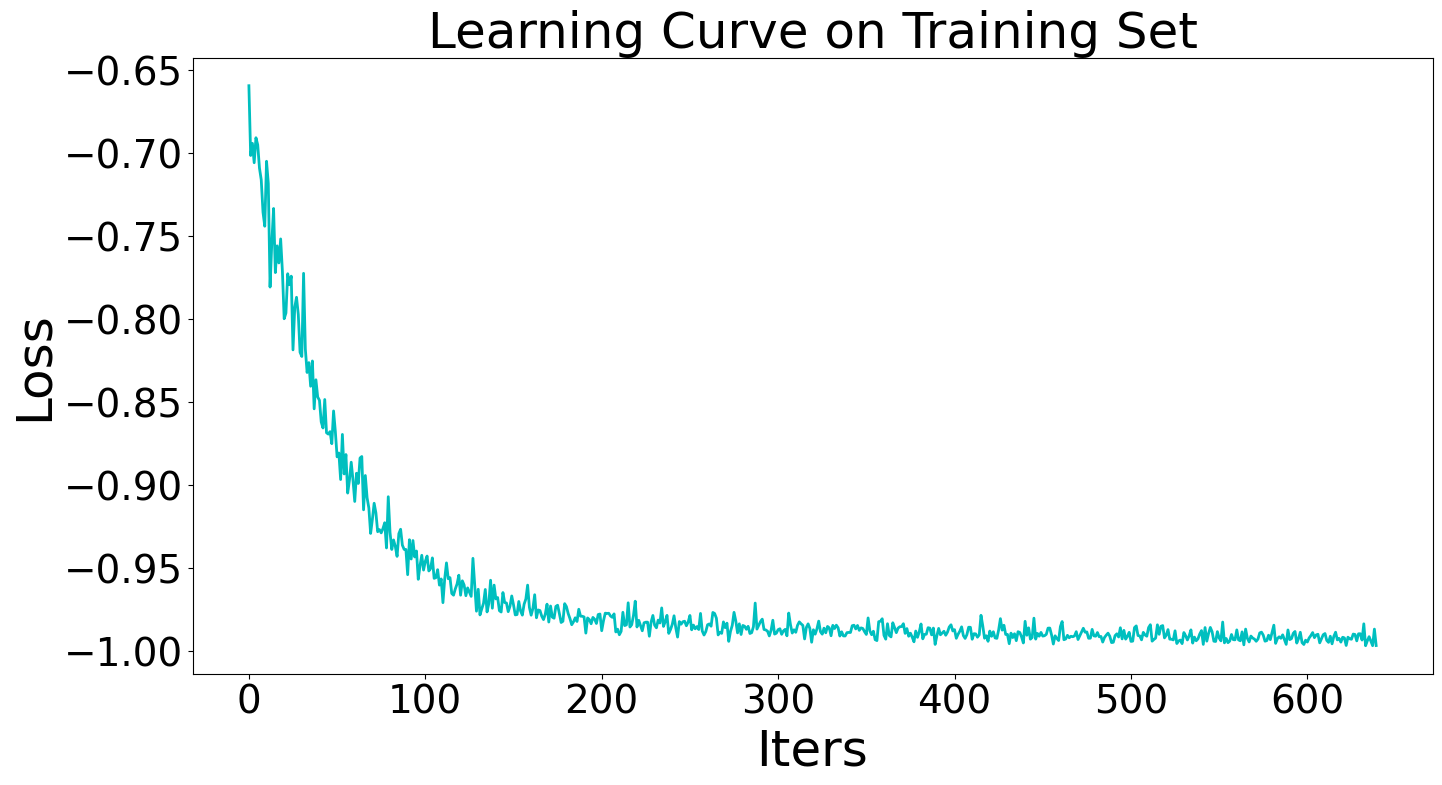

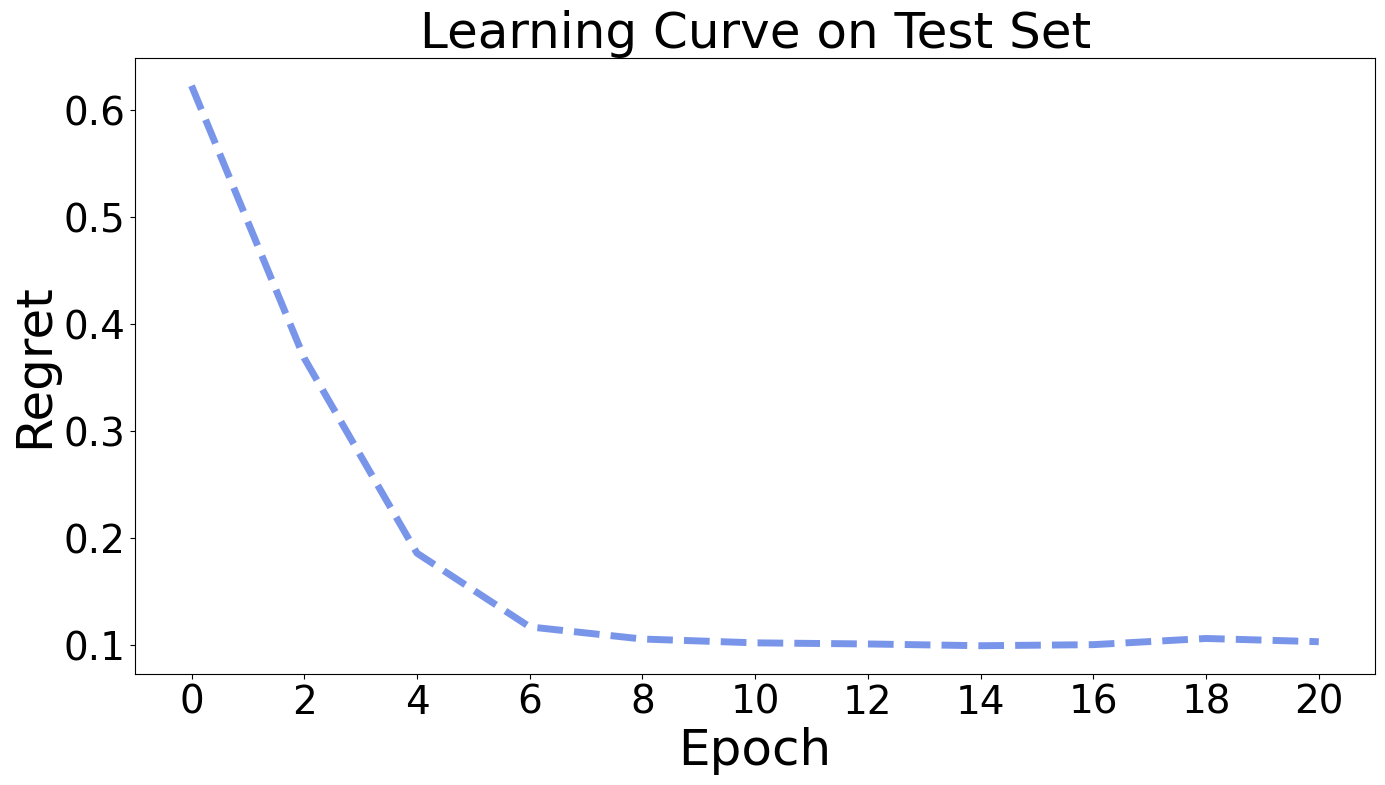

In [15]:
plot(loss_log, regret_log, num_epochs, log_step)

### Exact Method 

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel)

In [18]:
lr = 5e-3
num_epochs = 20
log_step = 2
loss_log, regret_log = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9955, Regret: 37.5255%
Epoch   2, Loss:  -0.9996, Regret: 14.6780%
Epoch   4, Loss:  -0.9996, Regret: 10.3320%
Epoch   6, Loss:  -0.9998, Regret:  9.5755%
Epoch   8, Loss:  -0.9999, Regret:  9.4938%
Epoch  10, Loss:  -1.0000, Regret:  9.8030%
Epoch  12, Loss:  -1.0000, Regret: 10.8187%
Epoch  14, Loss:  -1.0000, Regret: 10.2869%
Epoch  16, Loss:  -1.0000, Regret: 11.4942%
Epoch  18, Loss:  -1.0000, Regret: 11.1788%
Elapsed Time: 127.85 Sec


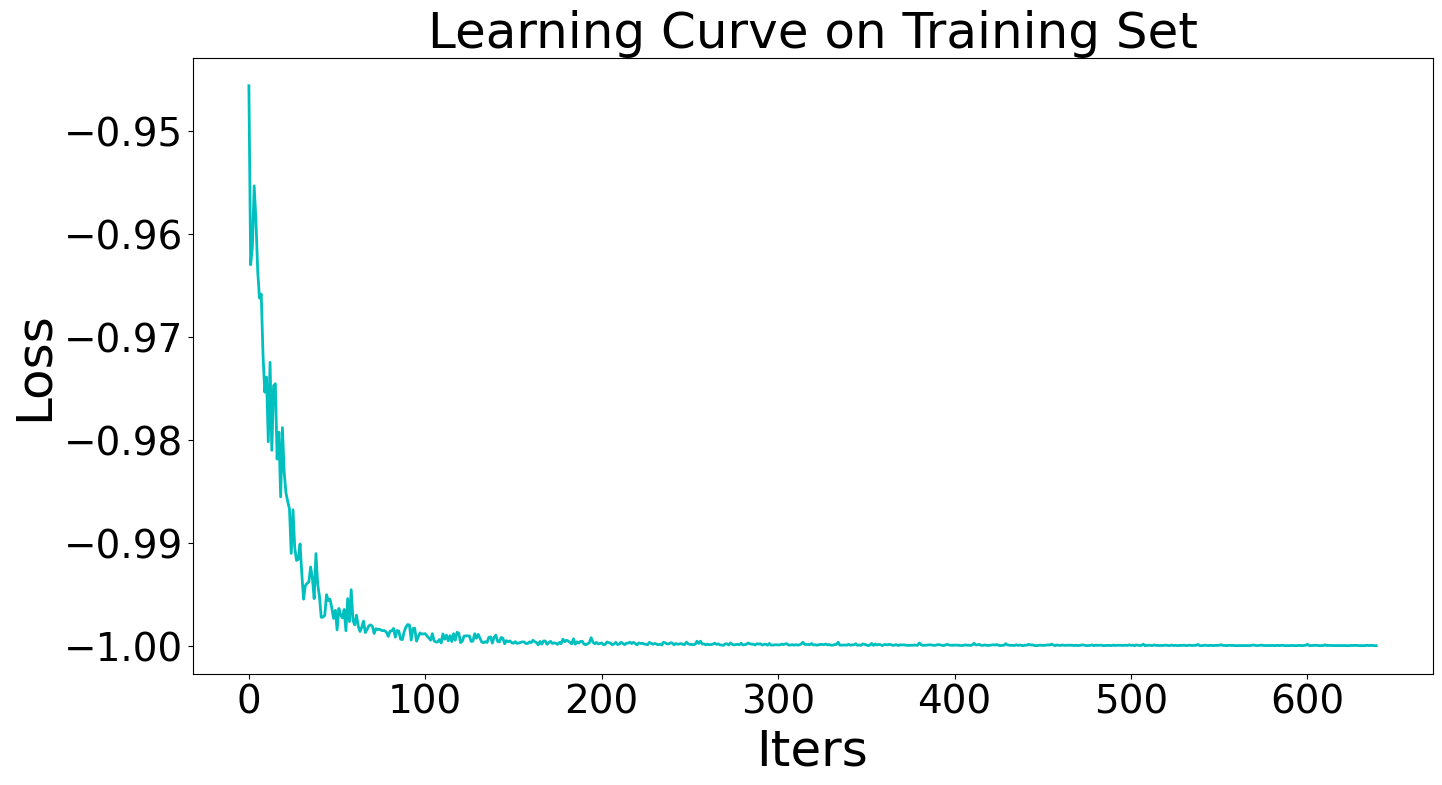

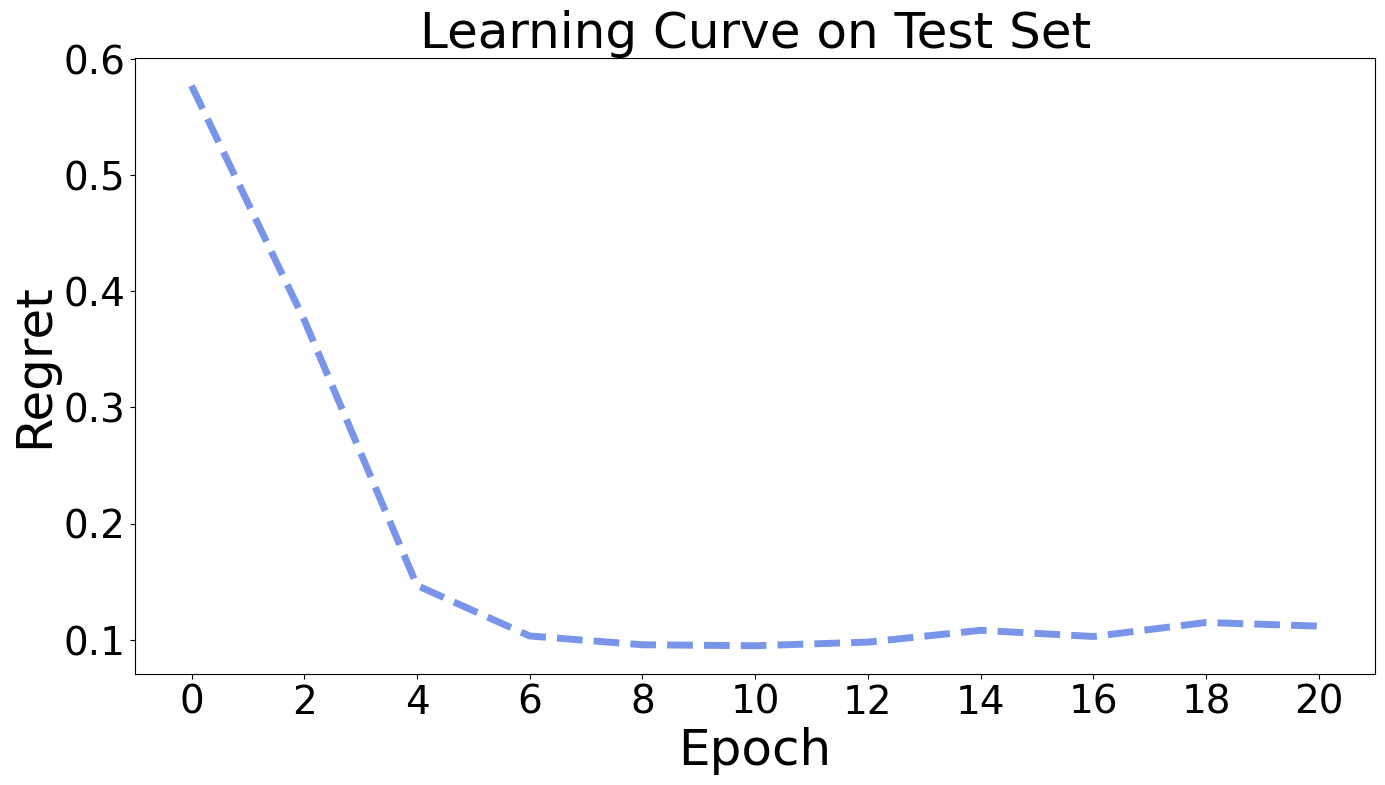

In [19]:
plot(loss_log, regret_log, num_epochs, log_step)